<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/master/red_neuronal_densa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

#modulos sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#modulos keras
from keras.models import Sequential
from keras.layers import Dense,Flatten

In [4]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_2.csv")
modo_3 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_3.csv")
modo_4 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_4.csv")
modo_5 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_5.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/residuo.csv")
modo_1["Fecha"] = pd.to_datetime(modo_1["Fecha"],format='%Y-%m-%d')
modo_2["Fecha"] = pd.to_datetime(modo_2["Fecha"],format='%Y-%m-%d')
modo_3["Fecha"] = pd.to_datetime(modo_3["Fecha"],format='%Y-%m-%d')
modo_4["Fecha"] = pd.to_datetime(modo_4["Fecha"],format='%Y-%m-%d')
modo_5["Fecha"] = pd.to_datetime(modo_5["Fecha"],format='%Y-%m-%d')
residuo["Fecha"] = pd.to_datetime(residuo["Fecha"],format='%Y-%m-%d')
modo_1.set_index("Fecha", inplace=True)
modo_2.set_index("Fecha", inplace=True)
modo_3.set_index("Fecha", inplace=True)
modo_4.set_index("Fecha", inplace=True)
modo_5.set_index("Fecha", inplace=True)
residuo.set_index("Fecha", inplace=True)

In [5]:
modo_1 = modo_1.asfreq('D')
modo_2 = modo_2.asfreq('D')
modo_3 = modo_3.asfreq('D')
modo_4 = modo_4.asfreq('D')
modo_5 = modo_5.asfreq('D')
residuo = residuo.asfreq('D')
modo_1.interpolate(inplace=True)
modo_2.interpolate(inplace=True)
modo_3.interpolate(inplace=True)
modo_4.interpolate(inplace=True)
modo_5.interpolate(inplace=True)
residuo.interpolate(inplace=True)

<Axes: xlabel='Fecha'>

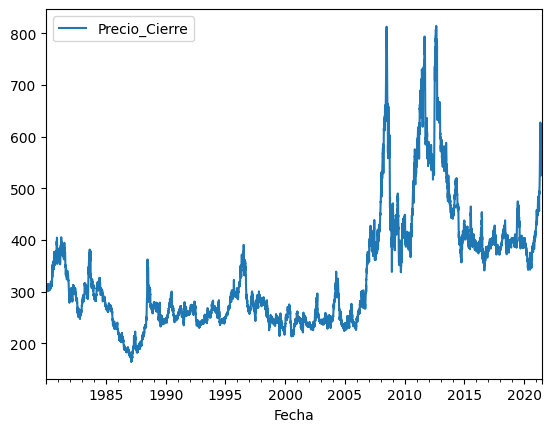

In [6]:
datos_emd =modo_1 + modo_2 + modo_3 + modo_4 + modo_5 + residuo
datos_emd.plot()

In [7]:
datos_emd.describe()

,Precio_Cierre
count,15155.000000
mean,334.254726
std,115.387240
min,164.250000
25%,249.000000
50%,290.250000
75%,395.000000
max,814.500000


In [8]:
#agregar características de retraso al conjunto de datos
def add_lags(df,pasos):
    target_map = df['Precio_Cierre'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = (df.index - pd.Timedelta(f'{i} days')).map(target_map)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [9]:
import optuna
from keras.optimizers import RMSprop

# Función de objetivo para Optuna
def objective(trial):
    # Definir el modelo Keras
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 7, 70), input_shape=(1,PASOS))) # Capa de entrada con unidades variables
    for i in range(trial.suggest_int('n_layers',1,2)): # Número de capas ocultas
        model.add(Dense(trial.suggest_int(f'units_{i}', 7, 70), activation='tanh')) # Capas ocultas con unidades variables
    model.add(Dense(1)) # Capa de salida

    # Compilar el modelo
    model.compile(optimizer=RMSprop(trial.suggest_float('learning_rate', 0.0001, 0.1)),
                  loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=3, batch_size=7, verbose=0)

    # Evaluar el modelo
    predictions = model.predict(X_val)
    mse = mean_squared_error(predictions.reshape(-1), y_val)

    return mse

In [10]:
# de pasos que vamos a utilizar para convertir nuestra serie de tiempo a aprendizaje supervizado
PASOS = 7

# Modelamos Modo 1

In [11]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_1_values = modo_1_values.reshape(-1, 1)
modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_sup = add_lags(modo_1_escalado, PASOS)
modo_1_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.016878,0.017245,0.051367,0.085490,0.119612,0.153734,0.026287,-0.111422
1980-01-10,-0.094281,-0.016878,0.017245,0.051367,0.085490,0.119612,0.153734,0.026287
1980-01-11,0.027963,-0.094281,-0.016878,0.017245,0.051367,0.085490,0.119612,0.153734
1980-01-12,0.013704,0.027963,-0.094281,-0.016878,0.017245,0.051367,0.085490,0.119612
1980-01-13,-0.000555,0.013704,0.027963,-0.094281,-0.016878,0.017245,0.051367,0.085490


In [12]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

datos_entrenamiento_m1_values= datos_entrenamiento_m1.values
datos_validacion_m1_values = datos_validacion_m1.values
datos_testeo_m1_values = datos_testeo_m1.values

X_train, y_train = datos_entrenamiento_m1_values[:, :-1], datos_entrenamiento_m1_values[:, -1]
X_val, y_val = datos_validacion_m1_values[:, :-1], datos_validacion_m1_values[:, -1]
X_test, y_test = datos_testeo_m1_values[:, :-1], datos_testeo_m1_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


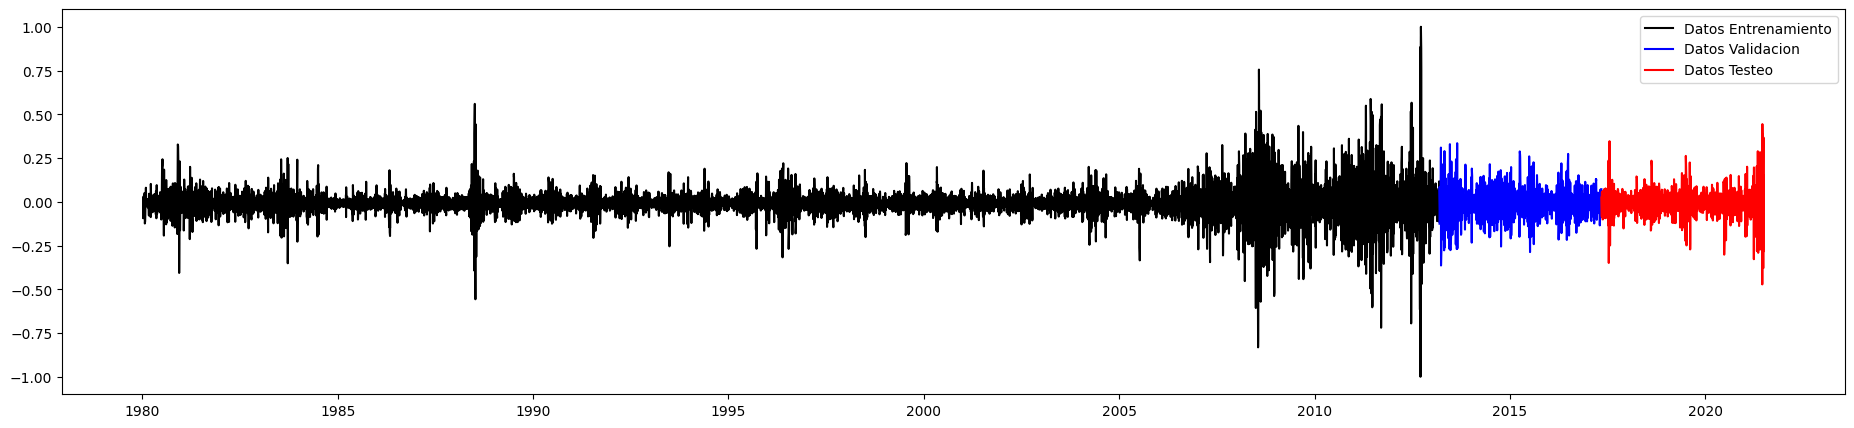

In [13]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [14]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [15]:
def modeloRD_m1():
  modelo = Sequential()
  modelo.add(Dense(units=47, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Dense(units=28,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.0083), loss='mse')
  return modelo

In [16]:
modelo = modeloRD_m1()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 9s 5ms/step - loss: 0.0072
Epoch 2/40
1732/1732 [==============================] - 6s 4ms/step - loss: 0.0067
Epoch 3/40
1732/1732 [==============================] - 5s 3ms/step - loss: 0.0066
Epoch 4/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0066
Epoch 5/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0066
Epoch 6/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0065
Epoch 7/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0065
Epoch 8/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0065
Epoch 9/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0065
Epoch 10/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0065
Epoch 11/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0065
Epoch 12/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0065
E

In [17]:
prediccion_validacion_m1 = modelo.predict(X_val)
prediccion_testeo_m1 = modelo.predict(X_test)

48/48 [==============================] - 0s 1ms/step


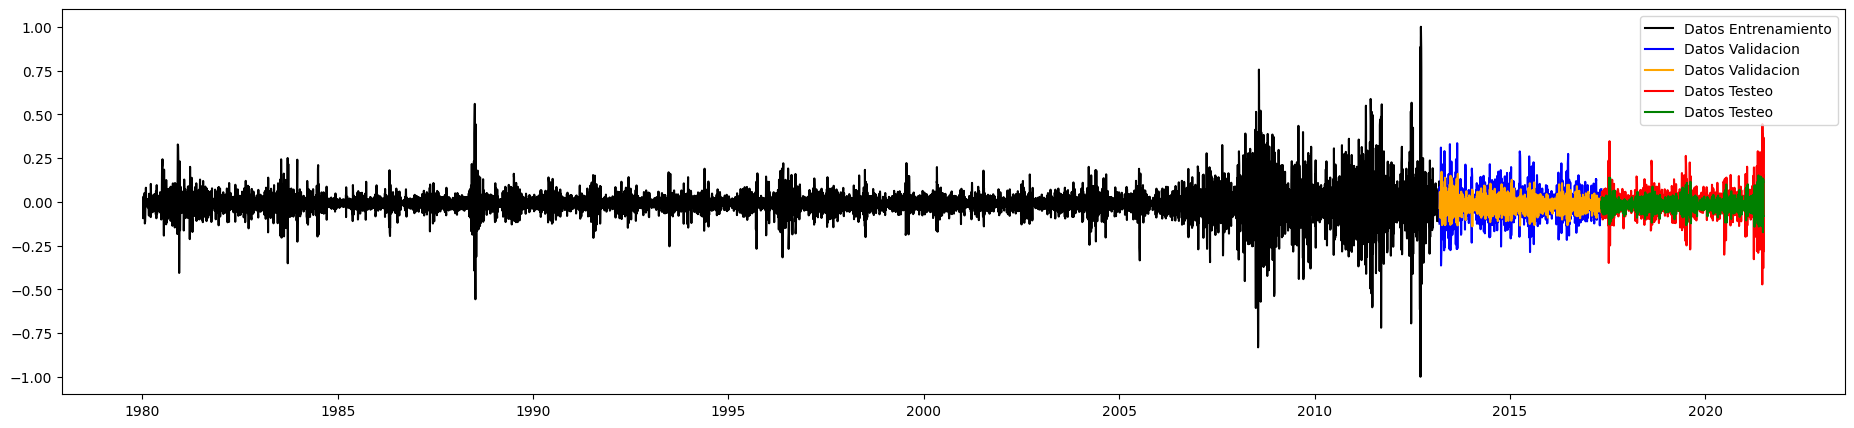

In [18]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m1.index,prediccion_validacion_m1,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m1.index,prediccion_testeo_m1,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

Esta en 0.098

In [19]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m1,datos_validacion_m1.Precio_Cierre))
print(score)

0.095797725


In [20]:
prediccion_validacion_m1 = modo_1_scaler.inverse_transform(prediccion_validacion_m1)
prediccion_testeo_m1 = modo_1_scaler.inverse_transform(prediccion_testeo_m1 )

# Modelamos modo 2

In [21]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_values = modo_2_values.reshape(-1, 1)
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_sup = add_lags(modo_2_escalado, PASOS)
modo_2_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,0.106661,0.118728,0.130794,0.142860,0.154927,0.166993,0.237516,0.307612
1980-01-10,0.081927,0.106661,0.118728,0.130794,0.142860,0.154927,0.166993,0.237516
1980-01-11,0.108178,0.081927,0.106661,0.118728,0.130794,0.142860,0.154927,0.166993
1980-01-12,0.120142,0.108178,0.081927,0.106661,0.118728,0.130794,0.142860,0.154927
1980-01-13,0.132105,0.120142,0.108178,0.081927,0.106661,0.118728,0.130794,0.142860


In [22]:
total_datos=len(modo_2_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

datos_entrenamiento_m2_values= datos_entrenamiento_m2.values
datos_validacion_m2_values = datos_validacion_m2.values
datos_testeo_m2_values = datos_testeo_m2.values

X_train, y_train = datos_entrenamiento_m2_values[:, :-1], datos_entrenamiento_m2_values[:, -1]
X_val, y_val = datos_validacion_m2_values[:, :-1], datos_validacion_m2_values[:, -1]
X_test, y_test = datos_testeo_m2_values[:, :-1], datos_testeo_m2_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


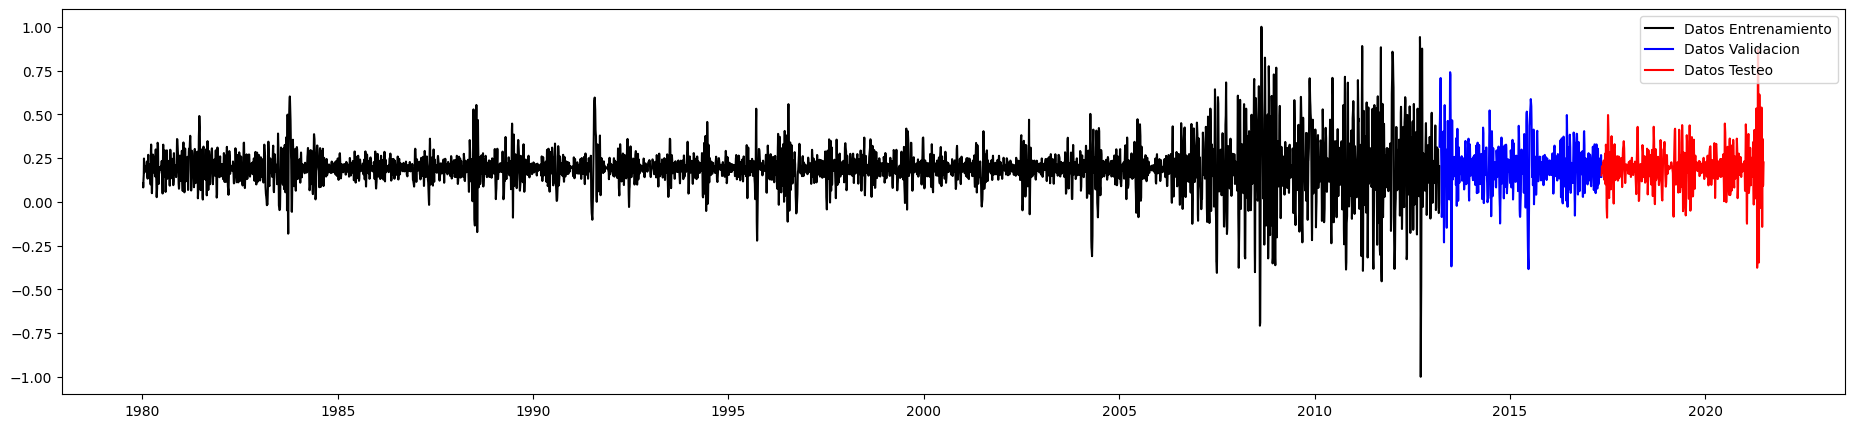

In [23]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [24]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [25]:
def modeloRD_m2():
  modelo = Sequential()
  modelo.add(Dense(units=46, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Dense(units=63,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.0037), loss='mse')
  return modelo


In [26]:
modelo = modeloRD_m2()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0025
Epoch 2/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 3/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0012
Epoch 4/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0012
Epoch 5/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 6/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 7/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 8/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 9/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 10/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 11/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 12/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0011
E

In [27]:
prediccion_validacion_m2 = modelo.predict(X_val)
prediccion_testeo_m2 = modelo.predict(X_test)

48/48 [==============================] - 0s 1ms/step


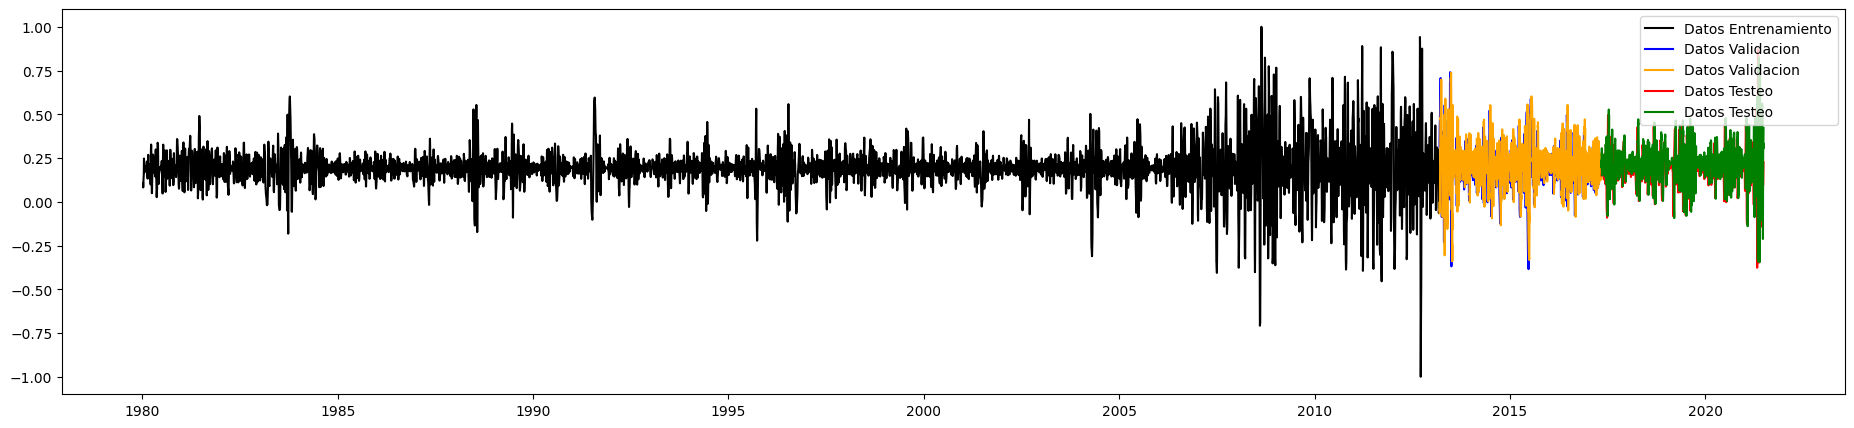

In [28]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m2.index,prediccion_validacion_m2,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m2.index,prediccion_testeo_m2,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

Esta actualmente en 0.2015

In [29]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m2,datos_validacion_m2.Precio_Cierre))
print(score)

0.20429951


In [30]:
prediccion_validacion_m2 = modo_2_scaler.inverse_transform(prediccion_validacion_m2)
prediccion_testeo_m2 = modo_2_scaler.inverse_transform(prediccion_testeo_m2 )

# Modelamos modo 3

In [31]:
modo_3_values = modo_3.values
modo_3_values = modo_3_values.astype('float32')
modo_3_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_3_values = modo_3_values.reshape(-1, 1)
modo_3_escalado =  pd.DataFrame(modo_3_scaler.fit_transform(modo_3_values), columns=modo_3.columns,index=modo_3.index)
modo_3_sup = add_lags(modo_3_escalado, PASOS)
modo_3_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,0.088243,0.091920,0.095597,0.099274,0.102951,0.106627,0.128091,0.151156
1980-01-10,0.074415,0.088243,0.091920,0.095597,0.099274,0.102951,0.106627,0.128091
1980-01-11,0.066249,0.074415,0.088243,0.091920,0.095597,0.099274,0.102951,0.106627
1980-01-12,0.065291,0.066249,0.074415,0.088243,0.091920,0.095597,0.099274,0.102951
1980-01-13,0.064333,0.065291,0.066249,0.074415,0.088243,0.091920,0.095597,0.099274


In [32]:
total_datos=len(modo_3_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m3 = modo_3_sup[:division_entrenamiento]
datos_validacion_m3 = modo_3_sup[division_entrenamiento:division_validacion]
datos_testeo_m3 = modo_3_sup[division_validacion:total_datos]

datos_entrenamiento_m3_values= datos_entrenamiento_m3.values
datos_validacion_m3_values = datos_validacion_m3.values
datos_testeo_m3_values = datos_testeo_m3.values

X_train, y_train = datos_entrenamiento_m3_values[:, :-1], datos_entrenamiento_m3_values[:, -1]
X_val, y_val = datos_validacion_m3_values[:, :-1], datos_validacion_m3_values[:, -1]
X_test, y_test = datos_testeo_m3_values[:, :-1], datos_testeo_m3_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


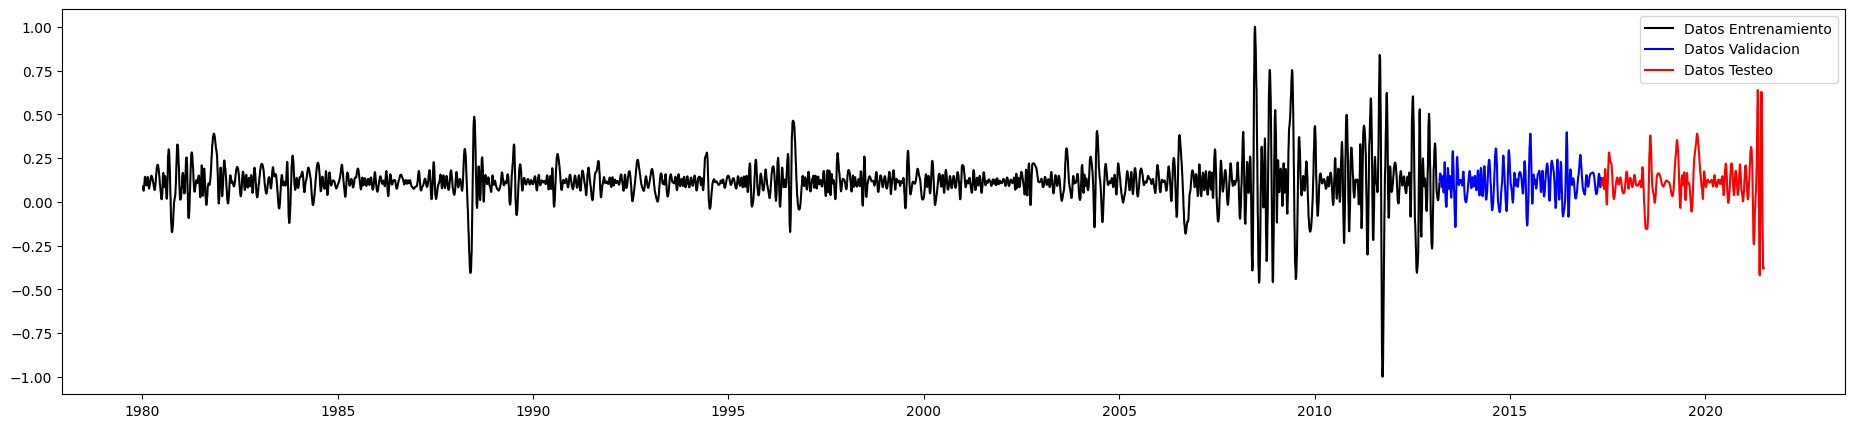

In [33]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m3.index,datos_validacion_m3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [34]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [35]:
def modeloRD_m3():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh'))
  #modelo.add(Dense(units=53, activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.0218), loss='mse')
  return modelo


In [36]:
modelo = modeloRD_m3()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 3s 1ms/step - loss: 0.0016
Epoch 2/40
1732/1732 [==============================] - 3s 1ms/step - loss: 0.0013
Epoch 3/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0013
Epoch 4/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 5/40
1732/1732 [==============================] - 3s 1ms/step - loss: 0.0013
Epoch 6/40
1732/1732 [==============================] - 3s 1ms/step - loss: 0.0013
Epoch 7/40
1732/1732 [==============================] - 3s 1ms/step - loss: 0.0013
Epoch 8/40
1732/1732 [==============================] - 3s 1ms/step - loss: 0.0012
Epoch 9/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 10/40
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0012
Epoch 11/40
1732/1732 [==============================] - 3s 1ms/step - loss: 0.0012
Epoch 12/40
1732/1732 [==============================] - 3s 1ms/step - loss: 0.0013
E

In [37]:
prediccion_validacion_m3 = modelo.predict(X_val)
prediccion_testeo_m3 = modelo.predict(X_test)

48/48 [==============================] - 0s 2ms/step


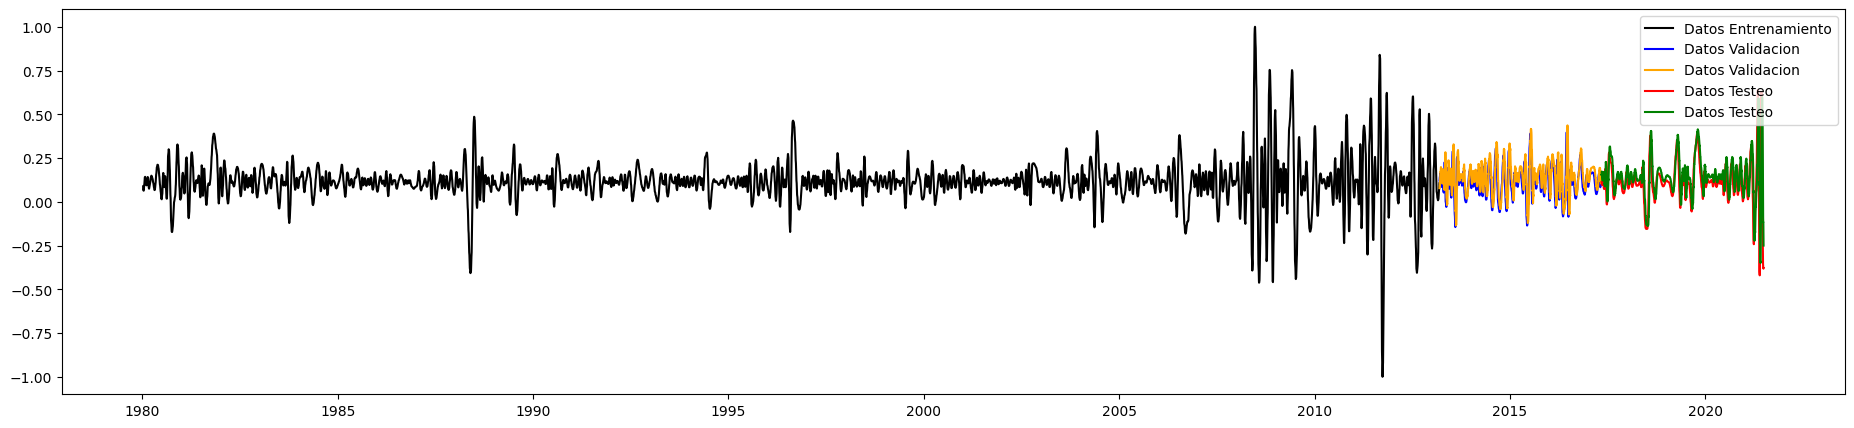

In [38]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m3.index,datos_validacion_m3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m3.index,prediccion_validacion_m3,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m3.index,prediccion_testeo_m3,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

esta en 0.0782

In [39]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m3,datos_validacion_m3.Precio_Cierre))
print(score)

0.08533689


In [40]:
prediccion_validacion_m3 = modo_3_scaler.inverse_transform(prediccion_validacion_m3)
prediccion_testeo_m3 = modo_3_scaler.inverse_transform(prediccion_testeo_m3 )

# modelamos modo 4


In [41]:
modo_4_values = modo_4.values
modo_4_values = modo_4_values.astype('float32')
modo_4_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_4_values = modo_4_values.reshape(-1, 1)
modo_4_escalado =  pd.DataFrame(modo_4_scaler.fit_transform(modo_4_values), columns=modo_4.columns,index=modo_4.index)
modo_4_sup = add_lags(modo_4_escalado, PASOS)
modo_4_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141,-0.052982,-0.046625,-0.039828
1980-01-10,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141,-0.052982,-0.046625
1980-01-11,-0.068195,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141,-0.052982
1980-01-12,-0.069320,-0.068195,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141
1980-01-13,-0.070446,-0.069320,-0.068195,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300


In [42]:
total_datos=len(modo_4_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m4 = modo_4_sup[:division_entrenamiento]
datos_validacion_m4 = modo_4_sup[division_entrenamiento:division_validacion]
datos_testeo_m4 = modo_4_sup[division_validacion:total_datos]

datos_entrenamiento_m4_values= datos_entrenamiento_m4.values
datos_validacion_m4_values = datos_validacion_m4.values
datos_testeo_m4_values = datos_testeo_m4.values

X_train, y_train = datos_entrenamiento_m4_values[:, :-1], datos_entrenamiento_m4_values[:, -1]
X_val, y_val = datos_validacion_m4_values[:, :-1], datos_validacion_m4_values[:, -1]
X_test, y_test = datos_testeo_m4_values[:, :-1], datos_testeo_m4_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


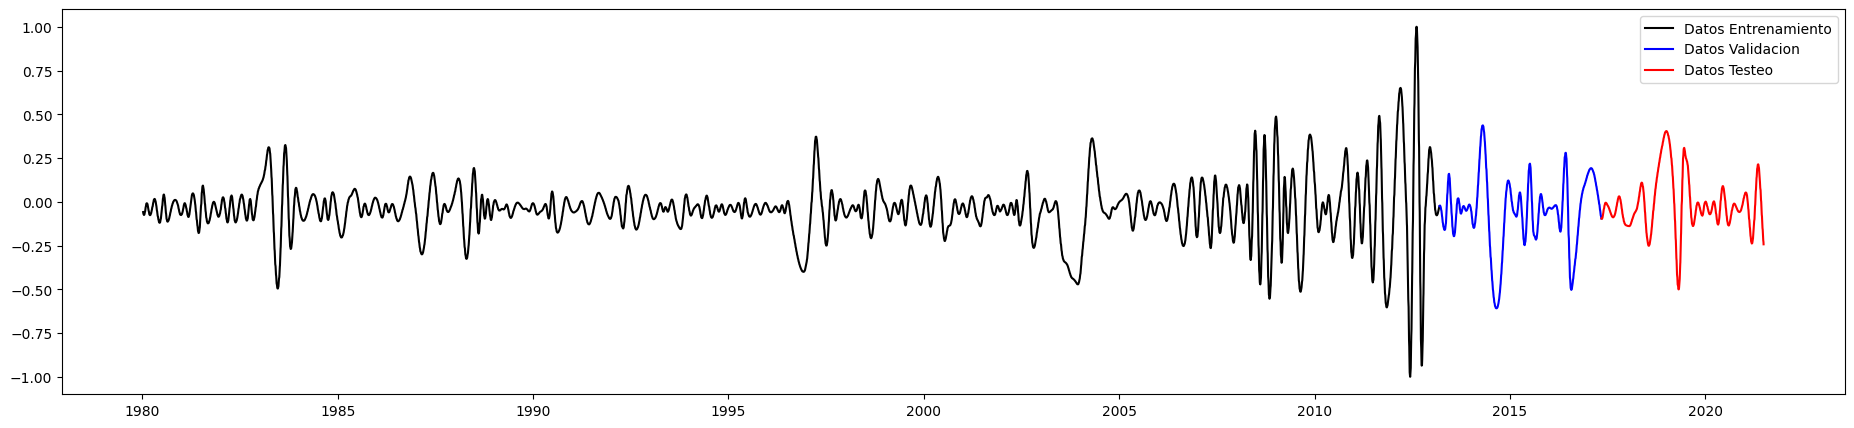

In [43]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [44]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [45]:
def modeloRD_m4():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer='rmsprop', loss='mse')
  return modelo


In [46]:
modelo = modeloRD_m4()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 3s 1ms/step - loss: 0.0018
Epoch 2/40
1732/1732 [==============================] - 3s 1ms/step - loss: 1.1805e-04
Epoch 3/40
1732/1732 [==============================] - 2s 1ms/step - loss: 9.7941e-05
Epoch 4/40
1732/1732 [==============================] - 3s 2ms/step - loss: 8.3121e-05
Epoch 5/40
1732/1732 [==============================] - 4s 2ms/step - loss: 7.2680e-05
Epoch 6/40
1732/1732 [==============================] - 3s 2ms/step - loss: 6.2506e-05
Epoch 7/40
1732/1732 [==============================] - 2s 1ms/step - loss: 5.4503e-05
Epoch 8/40
1732/1732 [==============================] - 3s 1ms/step - loss: 4.8082e-05
Epoch 9/40
1732/1732 [==============================] - 3s 1ms/step - loss: 4.2460e-05
Epoch 10/40
1732/1732 [==============================] - 4s 2ms/step - loss: 3.7653e-05
Epoch 11/40
1732/1732 [==============================] - 3s 2ms/step - loss: 3.4662e-05
Epoch 12/40
1732/1732 [======================

In [47]:
prediccion_validacion_m4 = modelo.predict(X_val)
prediccion_testeo_m4 = modelo.predict(X_test)

48/48 [==============================] - 0s 1ms/step


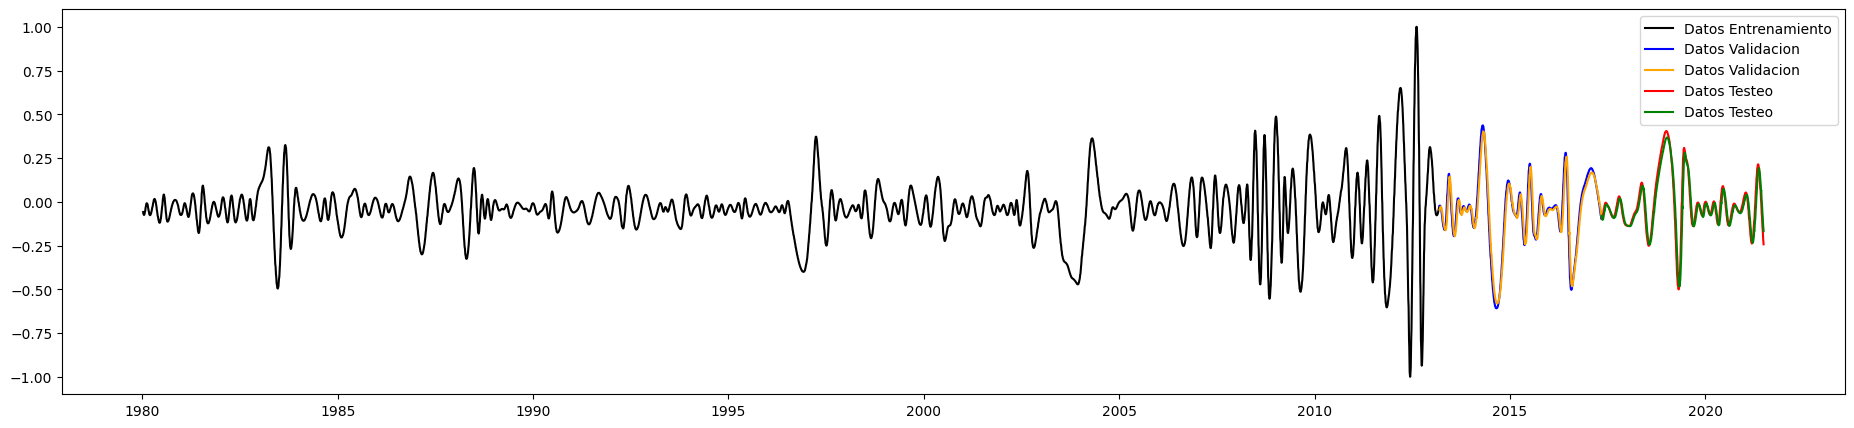

In [48]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m4.index,prediccion_validacion_m4,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m4.index,prediccion_testeo_m4,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

estamos en 0.047998

In [49]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m4,datos_validacion_m4.Precio_Cierre))
print(score)

0.05133969


In [50]:
prediccion_validacion_m4 = modo_4_scaler.inverse_transform(prediccion_validacion_m4)
prediccion_testeo_m4 = modo_4_scaler.inverse_transform(prediccion_testeo_m4 )

# Modelamos modo 5

In [51]:
modo_5_values = modo_5.values
modo_5_values = modo_5_values.astype('float32')
modo_5_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_5_values = modo_5_values.reshape(-1, 1)
modo_5_escalado =  pd.DataFrame(modo_5_scaler.fit_transform(modo_5_values), columns=modo_5.columns,index=modo_5.index)
modo_5_sup = add_lags(modo_5_escalado, PASOS)
modo_5_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,0.101723,0.102050,0.102378,0.102705,0.103032,0.103360,0.104982,0.106591
1980-01-10,0.100071,0.101723,0.102050,0.102378,0.102705,0.103032,0.103360,0.104982
1980-01-11,0.098404,0.100071,0.101723,0.102050,0.102378,0.102705,0.103032,0.103360
1980-01-12,0.097843,0.098404,0.100071,0.101723,0.102050,0.102378,0.102705,0.103032
1980-01-13,0.097282,0.097843,0.098404,0.100071,0.101723,0.102050,0.102378,0.102705


In [52]:
total_datos=len(modo_5_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m5 = modo_5_sup[:division_entrenamiento]
datos_validacion_m5 = modo_5_sup[division_entrenamiento:division_validacion]
datos_testeo_m5 = modo_5_sup[division_validacion:total_datos]

datos_entrenamiento_m5_values= datos_entrenamiento_m5.values
datos_validacion_m5_values = datos_validacion_m5.values
datos_testeo_m5_values = datos_testeo_m5.values

X_train, y_train = datos_entrenamiento_m5_values[:, :-1], datos_entrenamiento_m5_values[:, -1]
X_val, y_val = datos_validacion_m5_values[:, :-1], datos_validacion_m5_values[:, -1]
X_test, y_test = datos_testeo_m5_values[:, :-1], datos_testeo_m5_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


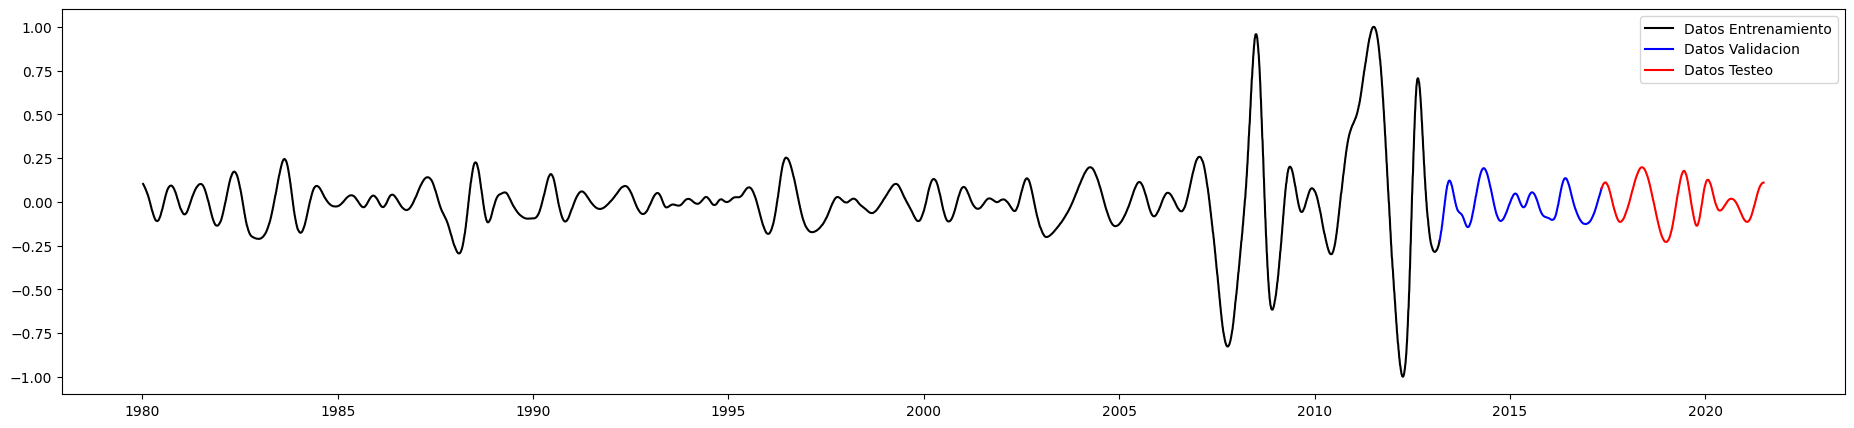

In [53]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [54]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [55]:
def modeloRD_m5():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer='rmsprop', loss='mse')
  return modelo

In [56]:
modelo = modeloRD_m5()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0029
Epoch 2/40
1732/1732 [==============================] - 3s 2ms/step - loss: 6.1867e-05
Epoch 3/40
1732/1732 [==============================] - 3s 1ms/step - loss: 3.0932e-05
Epoch 4/40
1732/1732 [==============================] - 3s 1ms/step - loss: 2.4939e-05
Epoch 5/40
1732/1732 [==============================] - 3s 1ms/step - loss: 2.3433e-05
Epoch 6/40
1732/1732 [==============================] - 3s 2ms/step - loss: 2.2410e-05
Epoch 7/40
1732/1732 [==============================] - 4s 2ms/step - loss: 2.0106e-05
Epoch 8/40
1732/1732 [==============================] - 3s 2ms/step - loss: 1.9470e-05
Epoch 9/40
1732/1732 [==============================] - 3s 1ms/step - loss: 1.9261e-05
Epoch 10/40
1732/1732 [==============================] - 2s 1ms/step - loss: 1.8355e-05
Epoch 11/40
1732/1732 [==============================] - 3s 1ms/step - loss: 1.8266e-05
Epoch 12/40
1732/1732 [======================

In [57]:
prediccion_validacion_m5 = modelo.predict(X_val)
prediccion_testeo_m5 = modelo.predict(X_test)

48/48 [==============================] - 0s 1ms/step


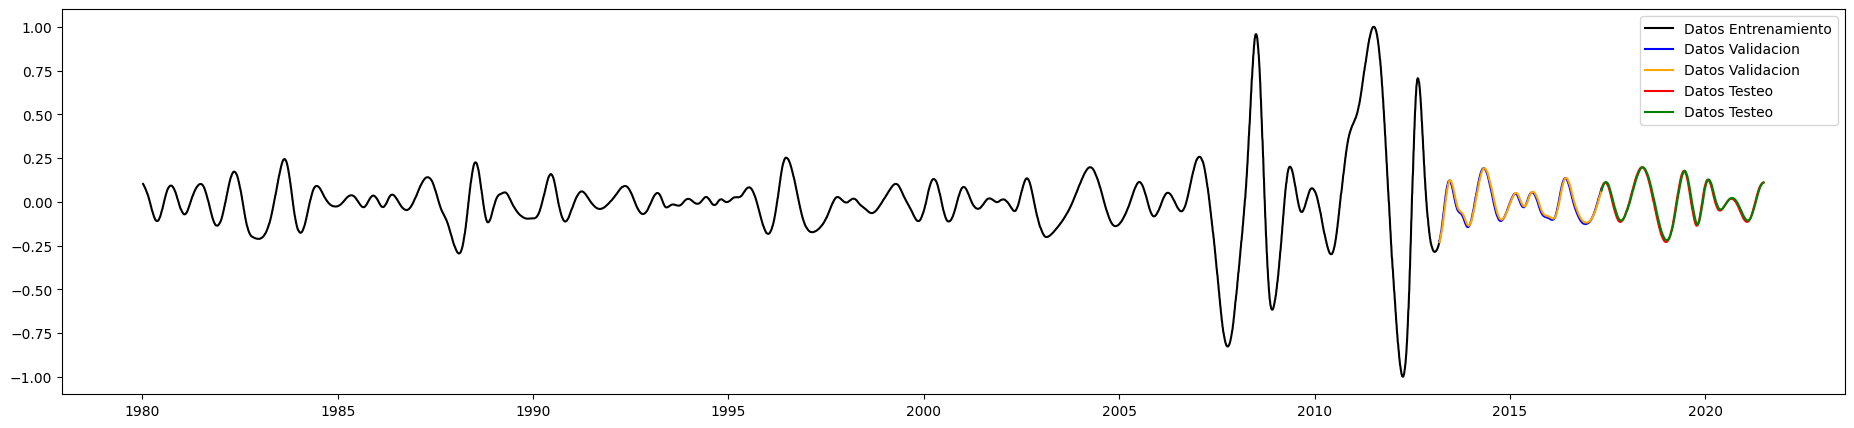

In [58]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m5.index,prediccion_validacion_m5,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m5.index,prediccion_testeo_m5,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

esta en 0.013

In [59]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m5,datos_validacion_m5.Precio_Cierre))
print(score)

0.014179273


In [60]:
prediccion_validacion_m5 = modo_5_scaler.inverse_transform(prediccion_validacion_m5)
prediccion_testeo_m5 = modo_5_scaler.inverse_transform(prediccion_testeo_m5 )

# Modelamos Residuo

In [61]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = add_lags(residuo_escalado, PASOS)
residuo_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725,-0.498891,-0.499712,-0.500525
1980-01-10,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725,-0.498891,-0.499712
1980-01-11,-0.496386,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725,-0.498891
1980-01-12,-0.496103,-0.496386,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725
1980-01-13,-0.495820,-0.496103,-0.496386,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560


In [62]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

datos_entrenamiento_residuo_values= datos_entrenamiento_residuo.values
datos_validacion_residuo_values = datos_validacion_residuo.values
datos_testeo_residuo_values = datos_testeo_residuo.values

X_train, y_train = datos_entrenamiento_residuo_values[:, :-1], datos_entrenamiento_residuo_values[:, -1]
X_val, y_val = datos_validacion_residuo_values[:, :-1], datos_validacion_residuo_values[:, -1]
X_test, y_test = datos_testeo_residuo_values[:, :-1], datos_testeo_residuo_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


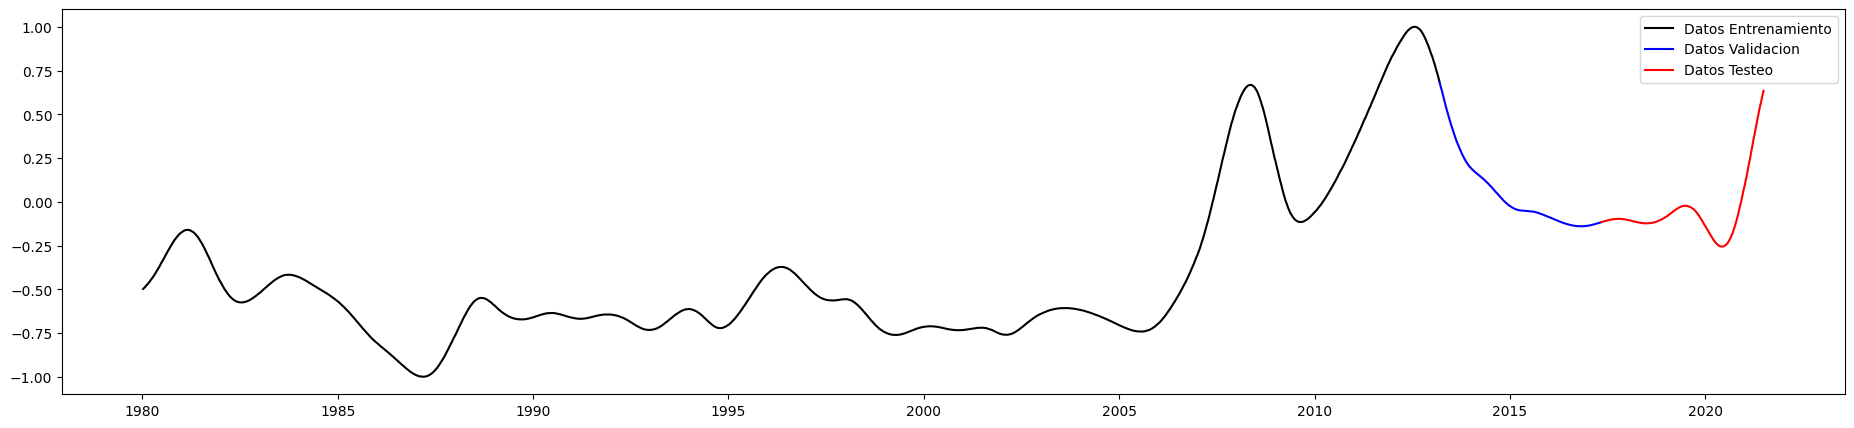

In [63]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [64]:
def modeloRD_residuo():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer='rmsprop', loss='mse')
  return modelo

In [65]:
modelo = modeloRD_residuo()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 3s 1ms/step - loss: 8.3316e-04
Epoch 2/40
1732/1732 [==============================] - 3s 2ms/step - loss: 1.1962e-04
Epoch 3/40
1732/1732 [==============================] - 4s 2ms/step - loss: 1.0618e-04
Epoch 4/40
1732/1732 [==============================] - 3s 2ms/step - loss: 9.9161e-05
Epoch 5/40
1732/1732 [==============================] - 3s 1ms/step - loss: 9.3042e-05
Epoch 6/40
1732/1732 [==============================] - 3s 1ms/step - loss: 8.6413e-05
Epoch 7/40
1732/1732 [==============================] - 3s 1ms/step - loss: 8.0947e-05
Epoch 8/40
1732/1732 [==============================] - 4s 2ms/step - loss: 7.7751e-05
Epoch 9/40
1732/1732 [==============================] - 3s 2ms/step - loss: 7.2035e-05
Epoch 10/40
1732/1732 [==============================] - 3s 1ms/step - loss: 6.5119e-05
Epoch 11/40
1732/1732 [==============================] - 3s 1ms/step - loss: 5.7557e-05
Epoch 12/40
1732/1732 [==================

In [66]:
prediccion_validacion_residuo = modelo.predict(X_val)
prediccion_testeo_residuo = modelo.predict(X_test)

48/48 [==============================] - 0s 1ms/step


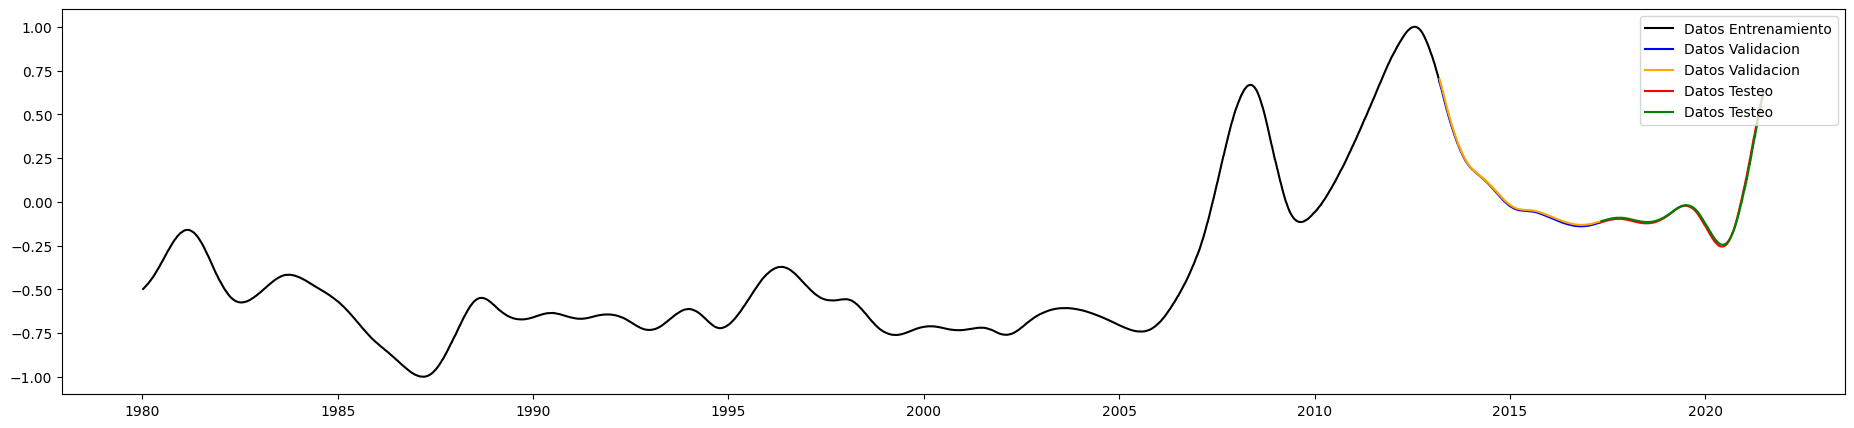

In [67]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,prediccion_validacion_residuo,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_testeo_residuo,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

el score esta en 12.27

In [68]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m5,datos_validacion_m5.Precio_Cierre))
print(score)

11.850337


In [69]:
prediccion_validacion_residuo = residuo_scaler.inverse_transform(prediccion_validacion_residuo)
prediccion_testeo_residuo = residuo_scaler.inverse_transform(prediccion_testeo_residuo  )

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [70]:
datos_emd
validacion = prediccion_validacion_m1 +prediccion_validacion_m2 + prediccion_validacion_m3 + prediccion_validacion_m4 + prediccion_validacion_m5 +  prediccion_validacion_residuo
testeo = prediccion_testeo_m1 +prediccion_testeo_m2 + prediccion_testeo_m3 + prediccion_testeo_m4 + prediccion_testeo_m5 + prediccion_testeo_residuo

In [71]:
total_datos=len(datos_emd.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

In [72]:
recm_validacion = np.sqrt(mean_squared_error( validacion,datos_validacion.Precio_Cierre[:-1]))
eam_validacion = mean_absolute_error( validacion,datos_validacion.Precio_Cierre[:-1])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.Precio_Cierre[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 11.251110256126841 
el error absoluto medio del modelo es: 8.569461752968385 
Error porcentual absoluto medio del modelo es: 0.019644470233741138


In [73]:
recm = np.sqrt(mean_squared_error( testeo,datos_testeo.Precio_Cierre))
eam = mean_absolute_error( testeo,datos_testeo.Precio_Cierre)
EPAM = mean_absolute_percentage_error(testeo,datos_testeo.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 11.844853445168667 
el error absoluto medio del modelo es: 8.26573169745156 
Error porcentual absoluto medio del modelo es: 0.019343676721491055


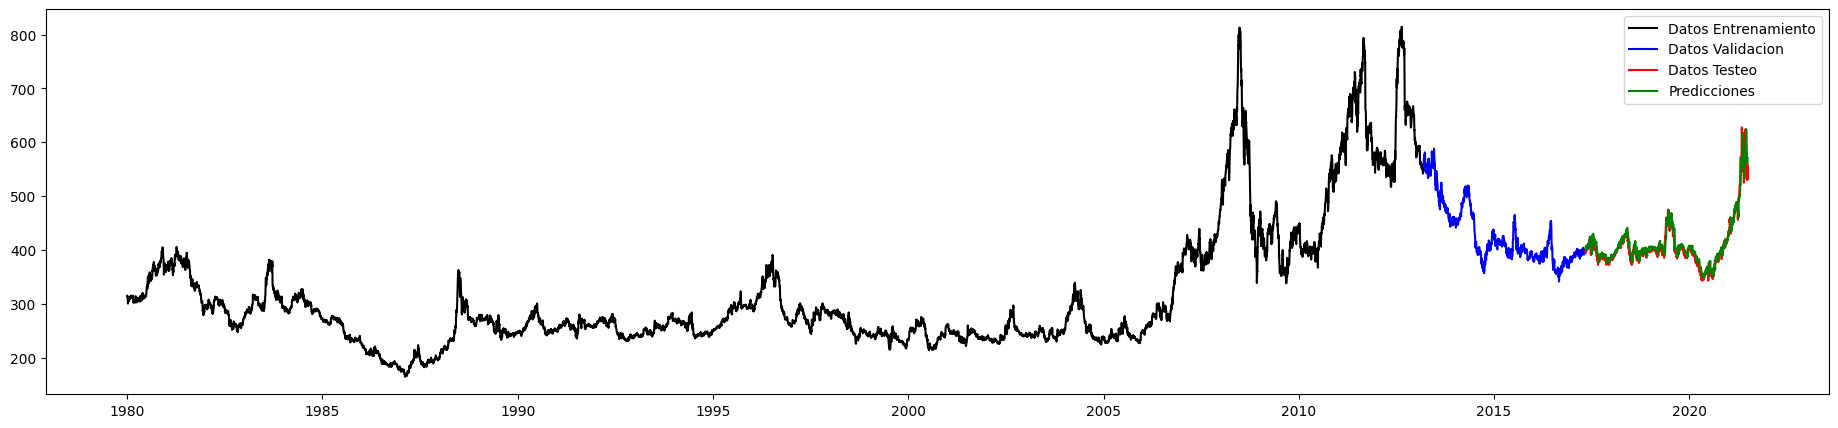

In [74]:

fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
#ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

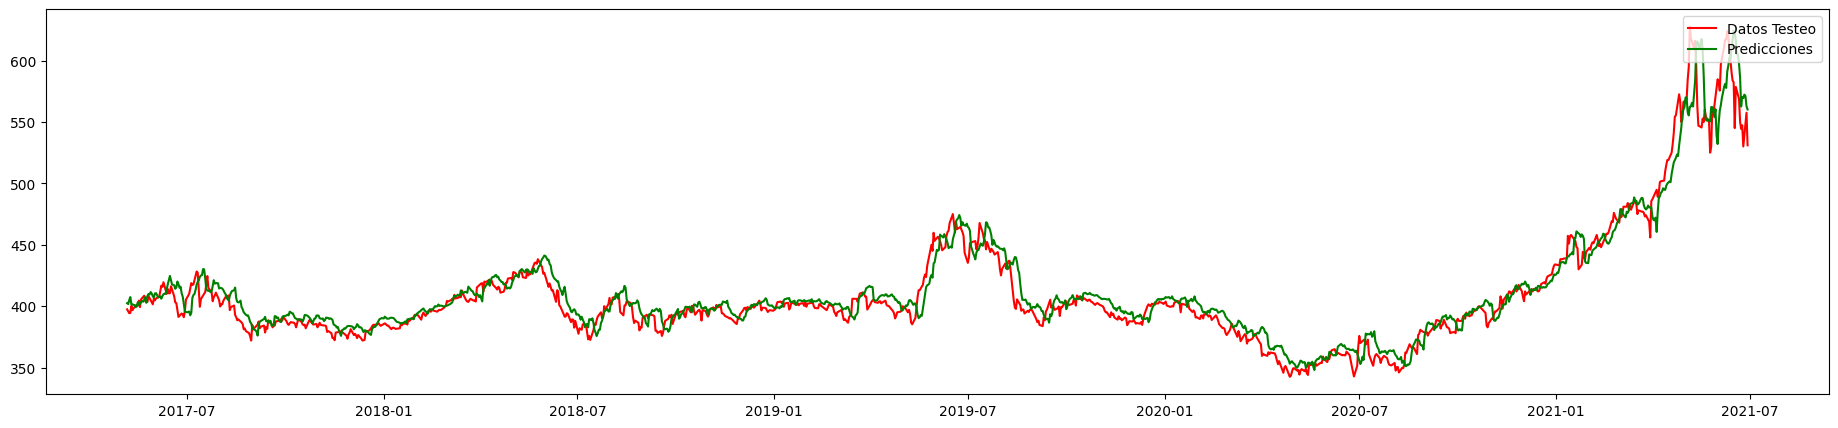

In [75]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [83]:
validacion =pd.DataFrame(validacion,index=datos_validacion.index[1:],columns=['Precio_Cierre'])
testeo = pd.DataFrame(testeo,index=datos_testeo.index,columns=['Precio_Cierre'])

In [85]:
validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Predicciones/validacion_red_densa.csv",index=True)
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Predicciones/testeo_red_densa.csv",index=True)
